# Lab 3: Clustering Analysis Using K-Means and K-Medoids Algorithms
# Name: Praveen Kumar Rayapati
# Course: Advanced Big Data and Data Mining



In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
# We'll implement K-Medoids manually since sklearn_extra might not be available
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# K-Medoids implementation
class KMedoids:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Initialize medoids randomly
        self.medoid_indices_ = np.random.choice(n_samples, self.n_clusters, replace=False)

        for iteration in range(self.max_iter):
            # Assign each point to nearest medoid
            distances = np.zeros((n_samples, self.n_clusters))
            for i, medoid_idx in enumerate(self.medoid_indices_):
                distances[:, i] = np.sum((X - X[medoid_idx])**2, axis=1)

            labels = np.argmin(distances, axis=1)

            # Update medoids
            new_medoid_indices = np.zeros(self.n_clusters, dtype=int)
            for i in range(self.n_clusters):
                cluster_points = np.where(labels == i)[0]
                if len(cluster_points) > 0:
                    # Calculate total distance for each point in cluster
                    total_distances = np.zeros(len(cluster_points))
                    for j, point_idx in enumerate(cluster_points):
                        total_distances[j] = np.sum([np.sum((X[point_idx] - X[other_idx])**2)
                                                   for other_idx in cluster_points])

                    # Choose point with minimum total distance as new medoid
                    new_medoid_indices[i] = cluster_points[np.argmin(total_distances)]
                else:
                    new_medoid_indices[i] = self.medoid_indices_[i]

            # Check for convergence
            if np.array_equal(self.medoid_indices_, new_medoid_indices):
                break

            self.medoid_indices_ = new_medoid_indices

        self.labels_ = labels
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


In [2]:
# Step 1: Load and Prepare the Dataset

print("\n" + "="*50)
print("STEP 1: LOAD AND PREPARE THE DATASET")
print("="*50)

# Load the Wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of classes: {len(target_names)}")
print(f"Target classes: {target_names}")

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Basic data exploration
print("\n--- Dataset Overview ---")
print(df.head())

print("\n--- Dataset Statistics ---")
print(df.describe())

print("\n--- Class Distribution ---")
class_counts = pd.Series(y).value_counts().sort_index()
for i, count in enumerate(class_counts):
    print(f"Class {i} ({target_names[i]}): {count} samples")

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Standardize the dataset using z-score normalization
print("\n--- Standardizing Dataset ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dataset standardized successfully!")
print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean of scaled data: {np.mean(X_scaled):.6f}")
print(f"Standard deviation of scaled data: {np.std(X_scaled):.6f}")




STEP 1: LOAD AND PREPARE THE DATASET
Dataset shape: (178, 13)
Number of features: 13
Number of classes: 3
Target classes: ['class_0' 'class_1' 'class_2']

--- Dataset Overview ---
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24     

In [3]:
# Step 2: Implement K-Means Clustering

print("\n" + "="*50)
print("STEP 2: IMPLEMENT K-MEANS CLUSTERING")
print("="*50)

# Implement K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

print("K-Means clustering completed!")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")

# Calculate performance metrics for K-Means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print(f"\nK-Means Performance Metrics:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Adjusted Rand Index (ARI): {kmeans_ari:.4f}")

# Analyze cluster distribution
print(f"\nK-Means Cluster Distribution:")
kmeans_cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for i, count in enumerate(kmeans_cluster_counts):
    print(f"Cluster {i}: {count} samples")




STEP 2: IMPLEMENT K-MEANS CLUSTERING
K-Means clustering completed!
Cluster centers shape: (3, 13)

K-Means Performance Metrics:
Silhouette Score: 0.2849
Adjusted Rand Index (ARI): 0.8975

K-Means Cluster Distribution:
Cluster 0: 65 samples
Cluster 1: 51 samples
Cluster 2: 62 samples


In [4]:
# Step 3: Implement K-Medoids Clustering

print("\n" + "="*50)
print("STEP 3: IMPLEMENT K-MEDOIDS CLUSTERING")
print("="*50)

# Implement K-Medoids with k=3
kmedoids = KMedoids(n_clusters=3, random_state=42)
kmedoids_labels = kmedoids.fit_predict(X_scaled)

print("K-Medoids clustering completed!")
print(f"Medoids indices: {kmedoids.medoid_indices_}")

# Calculate performance metrics for K-Medoids
kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)

print(f"\nK-Medoids Performance Metrics:")
print(f"Silhouette Score: {kmedoids_silhouette:.4f}")
print(f"Adjusted Rand Index (ARI): {kmedoids_ari:.4f}")

# Analyze cluster distribution
print(f"\nK-Medoids Cluster Distribution:")
kmedoids_cluster_counts = pd.Series(kmedoids_labels).value_counts().sort_index()
for i, count in enumerate(kmedoids_cluster_counts):
    print(f"Cluster {i}: {count} samples")




STEP 3: IMPLEMENT K-MEDOIDS CLUSTERING
K-Medoids clustering completed!
Medoids indices: [ 35  43 163]

K-Medoids Performance Metrics:
Silhouette Score: 0.1548
Adjusted Rand Index (ARI): 0.3413

K-Medoids Cluster Distribution:
Cluster 0: 89 samples
Cluster 1: 24 samples
Cluster 2: 65 samples



STEP 4: VISUALIZE AND COMPARE RESULTS
PCA explained variance ratio: [0.36198848 0.1920749 ]
Total variance explained: 0.5541


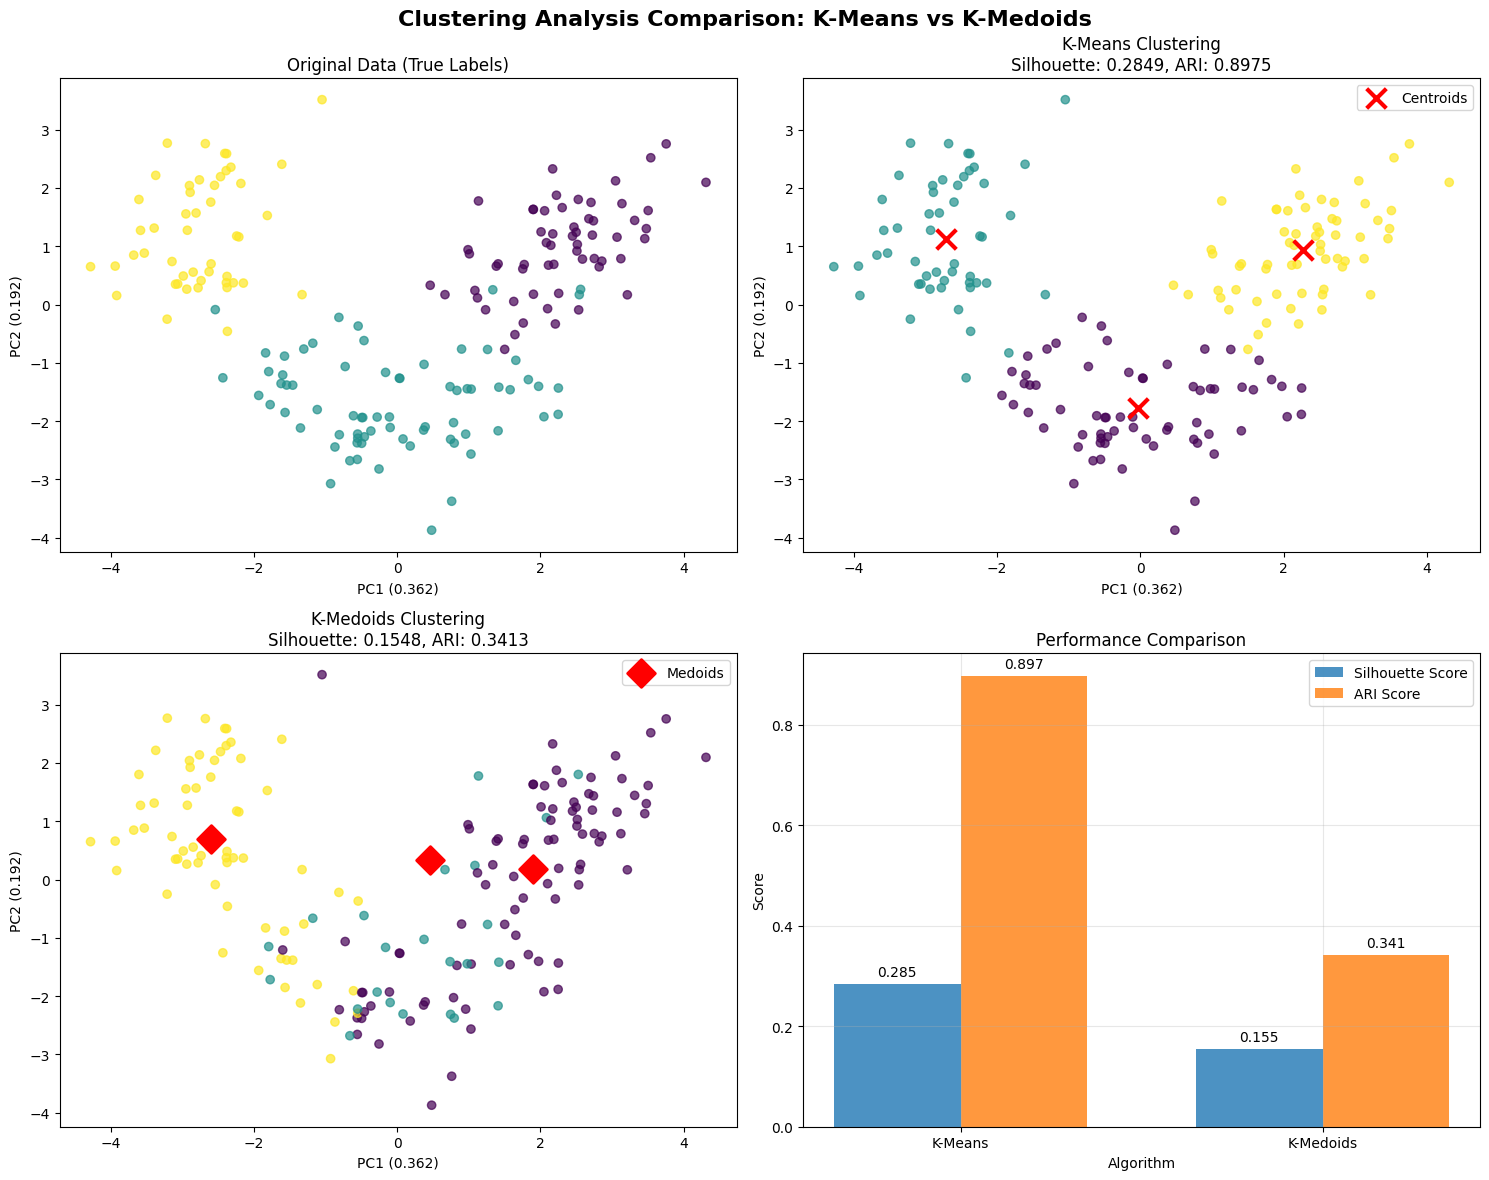


DETAILED ANALYSIS AND COMPARISON

--- Performance Metrics Summary ---
Algorithm    Silhouette Score ARI Score 
----------------------------------------
K-Means      0.2849           0.8975    
K-Medoids    0.1548           0.3413    

--- Performance Analysis ---
Better Silhouette Score: K-Means (difference: 0.1301)
Better ARI Score: K-Means (difference: 0.5562)

--- Cluster-Class Alignment Analysis ---

K-Means Cluster-Class Alignment:
Predicted Cluster   0   1   2
True Class                   
0                   0   0  59
1                  65   3   3
2                   0  48   0
Cluster 0 purity: 1.0000 (most common class: 1)
Cluster 1 purity: 0.9412 (most common class: 2)
Cluster 2 purity: 0.9516 (most common class: 0)
Overall purity: 0.9643

K-Medoids Cluster-Class Alignment:
Predicted Cluster   0   1   2
True Class                   
0                  53   6   0
1                  35  18  18
2                   1   0  47
Cluster 0 purity: 0.5955 (most common class: 0)
Cluster

In [5]:
# Step 4: Visualize and Compare Results

print("\n" + "="*50)
print("STEP 4: VISUALIZE AND COMPARE RESULTS")
print("="*50)

# Use PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Clustering Analysis Comparison: K-Means vs K-Medoids', fontsize=16, fontweight='bold')

# Original data with true labels
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Original Data (True Labels)')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')

# K-Means results
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
# Transform centroids to PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[0, 1].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                   c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0, 1].set_title(f'K-Means Clustering\nSilhouette: {kmeans_silhouette:.4f}, ARI: {kmeans_ari:.4f}')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
axes[0, 1].legend()

# K-Medoids results
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels, cmap='viridis', alpha=0.7)
# Transform medoids to PCA space
medoids_pca = pca.transform(X_scaled[kmedoids.medoid_indices_])
axes[1, 0].scatter(medoids_pca[:, 0], medoids_pca[:, 1],
                   c='red', marker='D', s=200, linewidths=2, label='Medoids')
axes[1, 0].set_title(f'K-Medoids Clustering\nSilhouette: {kmedoids_silhouette:.4f}, ARI: {kmedoids_ari:.4f}')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
axes[1, 0].legend()

# Performance comparison
algorithms = ['K-Means', 'K-Medoids']
silhouette_scores = [kmeans_silhouette, kmedoids_silhouette]
ari_scores = [kmeans_ari, kmedoids_ari]

x = np.arange(len(algorithms))
width = 0.35

axes[1, 1].bar(x - width/2, silhouette_scores, width, label='Silhouette Score', alpha=0.8)
axes[1, 1].bar(x + width/2, ari_scores, width, label='ARI Score', alpha=0.8)
axes[1, 1].set_xlabel('Algorithm')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(algorithms)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add score values on bars
for i, v in enumerate(silhouette_scores):
    axes[1, 1].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(ari_scores):
    axes[1, 1].text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Detailed Analysis and Comparison

print("\n" + "="*50)
print("DETAILED ANALYSIS AND COMPARISON")
print("="*50)

print("\n--- Performance Metrics Summary ---")
print(f"{'Algorithm':<12} {'Silhouette Score':<16} {'ARI Score':<10}")
print("-" * 40)
print(f"{'K-Means':<12} {kmeans_silhouette:<16.4f} {kmeans_ari:<10.4f}")
print(f"{'K-Medoids':<12} {kmedoids_silhouette:<16.4f} {kmedoids_ari:<10.4f}")

# Determine better performing algorithm
if kmeans_silhouette > kmedoids_silhouette:
    better_silhouette = "K-Means"
    silhouette_diff = kmeans_silhouette - kmedoids_silhouette
else:
    better_silhouette = "K-Medoids"
    silhouette_diff = kmedoids_silhouette - kmeans_silhouette

if kmeans_ari > kmedoids_ari:
    better_ari = "K-Means"
    ari_diff = kmeans_ari - kmedoids_ari
else:
    better_ari = "K-Medoids"
    ari_diff = kmedoids_ari - kmeans_ari

print(f"\n--- Performance Analysis ---")
print(f"Better Silhouette Score: {better_silhouette} (difference: {silhouette_diff:.4f})")
print(f"Better ARI Score: {better_ari} (difference: {ari_diff:.4f})")

# Confusion matrix-style analysis
print(f"\n--- Cluster-Class Alignment Analysis ---")

def analyze_cluster_alignment(true_labels, cluster_labels, algorithm_name):
    print(f"\n{algorithm_name} Cluster-Class Alignment:")
    alignment_matrix = pd.crosstab(true_labels, cluster_labels,
                                  rownames=['True Class'], colnames=['Predicted Cluster'])
    print(alignment_matrix)

    # Calculate purity for each cluster
    cluster_purity = []
    for cluster in range(3):
        cluster_mask = cluster_labels == cluster
        if np.sum(cluster_mask) > 0:
            cluster_classes = true_labels[cluster_mask]
            most_common_class = np.bincount(cluster_classes).argmax()
            purity = np.sum(cluster_classes == most_common_class) / len(cluster_classes)
            cluster_purity.append(purity)
            print(f"Cluster {cluster} purity: {purity:.4f} (most common class: {most_common_class})")

    overall_purity = np.mean(cluster_purity)
    print(f"Overall purity: {overall_purity:.4f}")
    return overall_purity

kmeans_purity = analyze_cluster_alignment(y, kmeans_labels, "K-Means")
kmedoids_purity = analyze_cluster_alignment(y, kmedoids_labels, "K-Medoids")

print(f"\n--- Final Recommendations ---")
print(f"Based on the analysis:")

if kmeans_silhouette > kmedoids_silhouette and kmeans_ari > kmedoids_ari:
    print("• K-Means performs better on both metrics")
    print("• K-Means creates more well-defined and accurate clusters")
elif kmedoids_silhouette > kmeans_silhouette and kmedoids_ari > kmeans_ari:
    print("• K-Medoids performs better on both metrics")
    print("• K-Medoids creates more well-defined and accurate clusters")
else:
    print("• Mixed results - each algorithm has strengths in different metrics")